# Introduction
This notebook is a personal project. The goal is to accurately forecast indoor/supply temperatures based on other variables such as external temperature, exhaust temperature, recirculation temperature and humidity. I aim to practise my feature engineering, data visualization and basic modelling.

In [85]:
import pandas as pd
import numpy as np
import glob
import time

import seaborn as sns
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport
from calculations import CalculateEnergy

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as md
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls

from functools import reduce

In [2]:
path = r"C:\Users\Roy\Desktop\ForecastTemperature"

def read_ahu_one():

    ahu_one = "\AHU1\\"

    exh = pd.read_csv(path + ahu_one + "ahu1_evac.csv")
    ext = pd.read_csv(path + ahu_one + "ahu1_ext.csv")
    hum = pd.read_csv(path + ahu_one + "ahu1_hum.csv")
    sup = pd.read_csv(path + ahu_one + "ahu1_in.csv")
    rec = pd.read_csv(path + ahu_one + "ahu1_rec.csv")

    exh.columns = ['date', 'exh'] # Exhaust temperature
    ext.columns = ['date', 'ext'] # Outdoor temperature
    hum.columns = ['date', 'hum'] # Humidity
    sup.columns = ['date', 'sup'] # Supply temperature
    rec.columns = ['date', 'rec'] # Recirculation temperature

    return exh, ext, hum, sup, rec

evac, ext, hum, sup, rec = read_ahu_one()

def MergeData():

    list_of_data = [evac, ext, hum, sup, rec]

    data = reduce(lambda  left,right: pd.merge(left,right,on=['date'],
                                            how='outer'), list_of_data)

    # Reorder columns.
    data = data[['date', 'exh', 'ext', 'hum', 'rec', 'sup']]

    return data

data = MergeData()

def PrepareData():

    evac, ext, hum, sup, rec = read_ahu_one()

    data = MergeData()

    return data

data = PrepareData()

In [3]:
def GenerateProfile(data, title_name, title_output):

    profile = ProfileReport(data, title=title_name)
    profile.to_file(output_file=title_output)

def CorrelationMap():
    
    print(data.columns)

    DC = data.iloc[:, 1:5]
    CRLN = DC.corr()

    f, ax = plt.subplots(figsize=(17, 14))
    sns.heatmap(CRLN, annot=True, fmt=".2f")
    plt.xticks(range(len(CRLN.columns)), CRLN.columns)
    plt.yticks(range(len(CRLN.columns)), CRLN.columns)
    plt.show()


In [4]:
def CalculateEnergy(data):
    """Calculates the energy necessary to
    attain a certain temperature."""

    # Creates two new columns: energy and sup_diff.
    # Energy will be calculated using specific heat.
    # Sup_diff calculates the difference in supply air temp.
    data['energy'] = None
    data['energy'] = pd.to_numeric(data['energy'], downcast='integer')
    data['sup_diff'] = data['sup'].diff()
    data['sup_diff'][0] = "34.6"

    # The approximate density of air (room temperature) is 1.292 per cubic meter (m3).
    # The cubic meter per hour in Cabin J14 is 439 m3/h.
    mass = (1.292 * 439) # Kilograms.
    specific_heat = 1012 # Joule.

    start = time.time()

    for row in data.itertuples():

        # Calculates the energy required to heat up a room.
        data['energy'] = (mass * specific_heat * data['sup_diff']).round(decimals=2)
        data['kwh'] = (data['energy'] * 0.0000002778)
        
        # Fills up zero values with the average value.
        data['energy'] = data['energy'].replace(to_replace=0, value=data['energy'].mean())

    print(data.head(n=15))

    # Sums up J and converts it to kWh.
    JouleSum = data['energy'].sum()
    kWhSum = (JouleSum * 0.0000002778)
    
    print("\nTotal energy use is {0:,.2f} in Joules.".format(JouleSum))
    print("This is {0:,.2f} in kWh.".format(kWhSum))

    stop = time.time()
    c_time = stop - start

    print("This computation took " + str((c_time / 60)) + " minutes.")

    return data

data = CalculateEnergy(data)

                        date   exh  ext   hum   rec   sup        energy  \
0   06-Jan-17 5:15:00 PM EET  27.2 -2.5  50.0  10.6  34.6  1.986020e+07   
1   06-Jan-17 5:20:00 PM EET  27.2 -2.5  50.0  10.6  34.7  5.739943e+04   
2   06-Jan-17 5:25:00 PM EET  27.2 -2.5  50.0  10.6  34.2 -2.869971e+05   
3   06-Jan-17 5:30:00 PM EET  27.2 -3.0  50.0  10.6  34.7  2.869971e+05   
4   06-Jan-17 5:35:00 PM EET  27.2 -3.5  50.0  10.6  34.2 -2.869971e+05   
5   06-Jan-17 5:40:00 PM EET  27.2 -3.5  50.0  10.1  34.2  1.599319e+02   
6   06-Jan-17 5:45:00 PM EET  27.2 -3.5  50.0  10.1  34.2  1.599319e+02   
7   06-Jan-17 5:50:00 PM EET  27.2 -3.5  50.0  10.1  34.2  1.599319e+02   
8   06-Jan-17 5:55:00 PM EET  27.2 -3.5  50.0  10.1  34.7  2.869971e+05   
9   06-Jan-17 6:00:00 PM EET  27.2 -4.0  50.0  10.1  34.7  1.599319e+02   
10  06-Jan-17 6:05:00 PM EET  27.2 -4.0  50.0  10.1  34.7  1.599319e+02   
11  06-Jan-17 6:10:00 PM EET  27.2 -3.5  50.0  10.1  34.7  1.599319e+02   
12  06-Jan-17 6:15:00 PM 

In [46]:
# Creating copies of the dataframe.
data_copy = pd.DataFrame.copy(data, deep=True)
data_v2 = pd.DataFrame.copy(data, deep=True)

## Feature Engineering

To optimise our model with additional variables for input, I calculate both the hourly running mean outdoor and indoor temperature, as well as the humidity. Aguilera et al. concluded that due to the thermal mass of a building, the outdoor air temperature does not have an instant effect on the air temperature indoors, which explains the importance of TRM as an input parameter to estimate TA. 

The hourly mean features are estimated based on the values within that particular hour that is otherwised measured at a five minute interval. I'm using the forward fill function as a safety measure, as the model will iterate over the values in each row. I have not tested the efficiency of also computing the hourly mean humidity, however tests will be done later to benchmark the performance and added value.

In [47]:
def CalculateRMT(data):
    """This function calculates the
    hourly running mean outdoor and 
    indoor temperatures and humidity."""
    
    data = data.set_index('date')
    data.index = pd.to_datetime(data.index, utc=True)

    # Resamples each variable into an hourly mean.
    hourly_mean_outside = data['ext'].resample('H').mean()
    hourly_mean_supply = data['sup'].resample('H').mean()
    hourly_mean_humidity = data['hum'].resample('H').mean()

    # Appends variables as fresh columns.
    data['rmot'] = hourly_mean_outside
    data['rmit'] = hourly_mean_supply
    data['rmoh'] = hourly_mean_humidity

    data['rmot'] = data['rmot'].fillna(method='ffill')
    data['rmit'] = data['rmit'].fillna(method='ffill')
    data['rmoh'] = data['rmoh'].fillna(method='ffill')

    return data

data = CalculateRMT(data)

In [43]:
# Save a kernel to feature engineer the occupancy status

In [82]:
dat = pd.DataFrame.copy(data, deep=True)

first_three = [1, 2, 3]
second_three = [4, 5, 6]
third_three = [7, 8, 9]
fourth_three = [10, 11, 12]

dat = dat['kwh'].resample('D').sum()

# Extract monthly data.
jan_to_mar = dat[dat.index.to_series().dt.month.isin(first_three)]
apr_to_jun = dat[dat.index.to_series().dt.month.isin(second_three)]
jul_to_sep = dat[dat.index.to_series().dt.month.isin(third_three)]
okt_to_dec = dat[dat.index.to_series().dt.month.isin(fourth_three)]

jan_to_mar = pd.Series.to_frame(jan_to_mar)

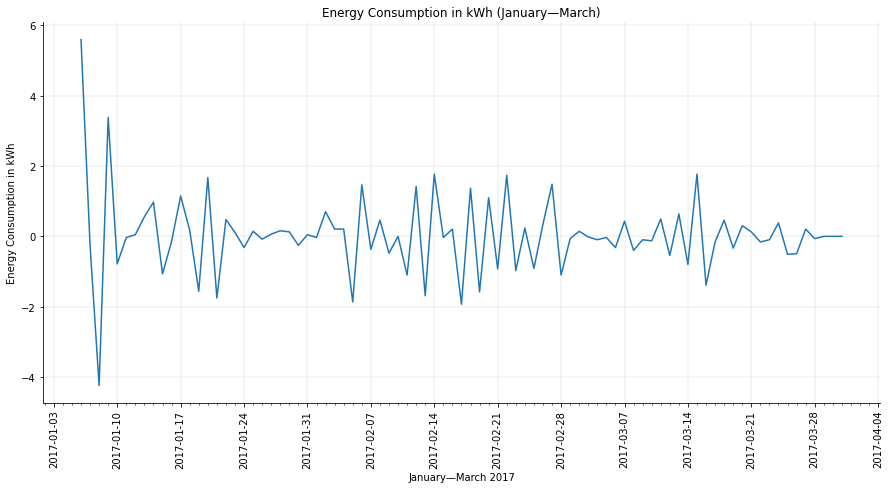

In [109]:
fig, ax = plt.subplots(figsize=(15, 7))

sns.lineplot(ax=ax, x='date', y='kwh', 
             data=jan_to_mar).set_title('Energy Consumption in kWh (January—March)')

# Sets the large ticks at the beginning of each week.
ax.xaxis.set_major_locator(md.WeekdayLocator(byweekday = 1))
ax.xaxis.set_minor_locator(md.DayLocator(interval = 1))

# Sets the rotation degree for readability.
plt.setp(ax.xaxis.get_majorticklabels(), rotation = 90)
ax.xaxis.set_major_formatter(md.DateFormatter('%Y-%m-%d'))

plt.xlabel('January—March 2017')
plt.ylabel('Energy Consumption in kWh')

plt.grid(linewidth=0.25)
sns.despine()